## Tensorflow 2.0 RC Serving with Keras

Train and export a simple Softmax Regression TensorFlow model.
The model is from the TensorFlow "MNIST For ML Beginner" tutorial. This program
simply follows all its training instructions, and uses TensorFlow SavedModel to
export the trained model with proper signatures that can be loaded by standard
tensorflow_model_server.
<br>
Usage: mnist_saved_model.py [--training_iteration=x] [--model_version=y] export_dir
<br>
https://www.tensorflow.org/beta/guide/saved_model#exporting_custom_models

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

(1, 224, 224, 3)


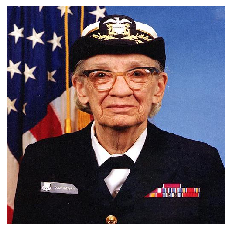

In [42]:
file = tf.keras.utils.get_file(
    "grace_hopper.jpg",
    "https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")
img = tf.keras.preprocessing.image.load_img(file, target_size=[224, 224])
plt.imshow(img)
plt.axis('off')
x = tf.keras.preprocessing.image.img_to_array(img)
x = tf.keras.applications.mobilenet.preprocess_input(x[tf.newaxis,...])
print(x.shape)

In [44]:
#tf.keras.applications.vgg19.decode_predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())
print(labels_path)
print(imagenet_labels, imagenet_labels.shape)

/home/bai/.keras/datasets/ImageNetLabels.txt
['background' 'tench' 'goldfish' ... 'bolete' 'ear' 'toilet tissue'] (1001,)


In [233]:
pretrained_model = tf.keras.applications.MobileNet()
result_before_save = pretrained_model(x)
print(result_before_save.shape)

decoded = imagenet_labels[np.argsort(result_before_save)[0,::-1][:5]+1]
print("Result before saving:\n", decoded)

(1, 1000)
Result before saving:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube']


In [5]:
tf.saved_model.save(pretrained_model, "/tmp/mobilenet/1/")

In [6]:
!saved_model_cli show --dir /tmp/mobilenet/1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_input_1:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['act_softmax'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1000)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [7]:
loaded = tf.saved_model.load("/tmp/mobilenet/1/")
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


In [236]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'act_softmax': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='act_softmax')}


In [48]:
labeling = infer(tf.constant(x))[pretrained_model.output_names[0]]
decoded = imagenet_labels[np.argsort(labeling)[0,::-1][:5]+1]
print("Result after saving and loading:\n", decoded, decoded.shape)

Result after saving and loading:
 ['military uniform' 'bow tie' 'suit' 'bearskin' 'pickelhaube'] (5,)


In [10]:
!ls /tmp/mobilenet/1

assets	saved_model.pb	variables


In [11]:
!saved_model_cli show --dir /tmp/mobilenet/1 --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


Exporting custom models
<br>
In the first section, tf.saved_model.save automatically determined a signature for the tf.keras.Model object. This worked because Keras Model objects have an unambiguous method to export and known input shapes. tf.saved_model.save works just as well with low-level model building APIs, but you will need to indicate which function to use as a signature if you're planning to serve a model.

In [15]:
class CustomModule(tf.Module):

    def __init__(self):
        super(CustomModule, self).__init__()
        self.v = tf.Variable(1.)

    @tf.function
    def __call__(self, x):
        return x * self.v

    @tf.function(input_signature=[tf.TensorSpec([], tf.float32)])
    def mutate(self, new_v):
        self.v.assign(new_v)

module = CustomModule()


In [16]:
module(tf.constant(0.))
tf.saved_model.save(module, "/tmp/module_no_signatures")

In [17]:
imported = tf.saved_model.load("/tmp/module_no_signatures")
assert 3. == imported(tf.constant(3.)).numpy()
imported.mutate(tf.constant(2.))
assert 6. == imported(tf.constant(3.)).numpy()

In [19]:
# will not work!
#imported(tf.constant([3.]))

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * Tensor("x:0", shape=(1,), dtype=float32)
  Keyword arguments: {}

Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(), dtype=tf.float32, name='x')
  Keyword arguments: {}

In [20]:
module.__call__.get_concrete_function(x=tf.TensorSpec([None], tf.float32))
tf.saved_model.save(module, "/tmp/module_no_signatures")
imported = tf.saved_model.load("/tmp/module_no_signatures")
assert [3.] == imported(tf.constant([3.])).numpy()

In [21]:
!saved_model_cli show --dir /tmp/module_no_signatures --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"


In [22]:
call = module.__call__.get_concrete_function(tf.TensorSpec(None, tf.float32))
tf.saved_model.save(module, "/tmp/module_with_signature", signatures=call)

In [23]:
!saved_model_cli show --dir /tmp/module_with_signature --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['x'] tensor_info:
      dtype: DT_FLOAT
      shape: unknown_rank
      name: serving_default_x:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_0'] tensor_info:
      dtype: DT_FLOAT
      shape: unknown_rank
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [24]:
imported = tf.saved_model.load("/tmp/module_with_signature")
signature = imported.signatures["serving_default"]
assert [3.] == signature(x=tf.constant([3.]))["output_0"].numpy()
imported.mutate(tf.constant(2.))
assert [6.] == signature(x=tf.constant([3.]))["output_0"].numpy()
assert 2. == imported.v.numpy()

In [25]:
@tf.function(input_signature=[tf.TensorSpec([], tf.string)])
def parse_string(string_input):
    return imported(tf.strings.to_number(string_input))

signatures = {"serving_default": parse_string,
              "from_float": imported.signatures["serving_default"]}

tf.saved_model.save(imported, "/tmp/module_with_multiple_signatures", signatures)

In [29]:
!saved_model_cli show --dir /tmp/module_with_multiple_signatures --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "from_float"
SignatureDef key: "serving_default"


In [30]:
!saved_model_cli run --dir /tmp/module_with_multiple_signatures --tag_set serve --signature_def serving_default --input_exprs="string_input='3.'"

2019-09-17 10:56:38.534876: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-17 10:56:38.557857: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
2019-09-17 10:56:38.558139: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x3b67020 executing computations on platform Host. Devices:
2019-09-17 10:56:38.558166: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
W0917 10:56:38.558624 140500180879168 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow/python/tools/saved_model_cli.py:339: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf

In [28]:
!saved_model_cli run --dir /tmp/module_with_multiple_signatures --tag_set serve --signature_def from_float --input_exprs="x=3."

2019-09-17 10:56:28.978645: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-17 10:56:29.001907: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2208000000 Hz
2019-09-17 10:56:29.002140: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x421fdf0 executing computations on platform Host. Devices:
2019-09-17 10:56:29.002169: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
W0917 10:56:29.002708 140225866139456 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow/python/tools/saved_model_cli.py:339: load (from tensorflow.python.saved_model.loader_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf

In [31]:

optimizer = tf.optimizers.SGD(0.05)

def train_step():
    with tf.GradientTape() as tape:
        loss = (10. - imported(tf.constant(2.))) ** 2
    variables = tape.watched_variables()
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss

In [32]:
for _ in range(10):
    # "v" approaches 5, "loss" approaches 0
    print("loss={:.2f} v={:.2f}".format(train_step(), imported.v.numpy()))

W0917 10:58:29.899080 140496311969600 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


loss=36.00 v=3.20
loss=12.96 v=3.92
loss=4.67 v=4.35
loss=1.68 v=4.61
loss=0.60 v=4.77
loss=0.22 v=4.86
loss=0.08 v=4.92
loss=0.03 v=4.95
loss=0.01 v=4.97
loss=0.00 v=4.98


In [33]:
@tf.function(input_signature=[tf.TensorSpec([], tf.int32)])
def control_flow(x):
    if x < 0:
        tf.print("Invalid!")
    else:
        tf.print(x % 3)

to_export = tf.Module()
to_export.control_flow = control_flow
tf.saved_model.save(to_export, "/tmp/control_flow")


In [34]:
imported = tf.saved_model.load("/tmp/control_flow")
imported.control_flow(tf.constant(-1))  # Invalid!
imported.control_flow(tf.constant(2))   # 2
imported.control_flow(tf.constant(3))   # 0

Invalid!
2
0


In [35]:
input_column = tf.feature_column.numeric_column("x")
estimator = tf.estimator.LinearClassifier(feature_columns=[input_column])

def input_fn():
    return tf.data.Dataset.from_tensor_slices(
        ({"x": [1., 2., 3., 4.]}, [1, 1, 0, 0])).repeat(200).shuffle(64).batch(16)
estimator.train(input_fn)

serving_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
  tf.feature_column.make_parse_example_spec([input_column]))
export_path = estimator.export_saved_model(
  "/tmp/from_estimator/", serving_input_fn)


W0917 10:59:23.754040 140496311969600 estimator.py:1811] Using temporary folder as model directory: /tmp/tmpp1q8snp6
W0917 10:59:23.765188 140496311969600 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0917 10:59:24.085544 140496311969600 deprecation.py:323] From /home/bai/.virtualenvs/tensorflow2/lib/python3.6/site-packages/tensorflow_estimator/python/estimator/canned/linear.py:308: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0917 10:59:24.249605 140496311969600 deprecation.py:506] From /home/bai/.virtualenvs/tensorflow2/

In [38]:
imported = tf.saved_model.load(export_path)

def predict(x):
    example = tf.train.Example()
    example.features.feature["x"].float_list.value.extend([x])
    return imported.signatures["predict"](examples=tf.constant([example.SerializeToString()]))

In [166]:
print(predict(1.5))
print(predict(3.5))

{'probabilities': <tf.Tensor: id=70121, shape=(1, 2), dtype=float32, numpy=array([[0.4332702, 0.5667297]], dtype=float32)>, 'logits': <tf.Tensor: id=70120, shape=(1, 1), dtype=float32, numpy=array([[0.26852095]], dtype=float32)>, 'class_ids': <tf.Tensor: id=70117, shape=(1, 1), dtype=int64, numpy=array([[1]])>, 'classes': <tf.Tensor: id=70118, shape=(1, 1), dtype=string, numpy=array([[b'1']], dtype=object)>, 'all_class_ids': <tf.Tensor: id=70115, shape=(1, 2), dtype=int32, numpy=array([[0, 1]], dtype=int32)>, 'logistic': <tf.Tensor: id=70119, shape=(1, 1), dtype=float32, numpy=array([[0.5667297]], dtype=float32)>, 'all_classes': <tf.Tensor: id=70116, shape=(1, 2), dtype=string, numpy=array([[b'0', b'1']], dtype=object)>}
{'probabilities': <tf.Tensor: id=70136, shape=(1, 2), dtype=float32, numpy=array([[0.7902524 , 0.20974763]], dtype=float32)>, 'logits': <tf.Tensor: id=70135, shape=(1, 1), dtype=float32, numpy=array([[-1.3264474]], dtype=float32)>, 'class_ids': <tf.Tensor: id=70132, sh